## Install the PGR-TK package

If neccessary, install the package into your python environment 
```
pip install --force /code/pgrtk-0.3.2-cp38-cp38-linux_x86_64.whl
```

In [1]:
import pgrtk
import os
import matplotlib.pyplot as plt
from IPython.display import SVG
%matplotlib inline

In [2]:
pgrtk.__version__

'pgrtk 0.3.2 (main:00d8eb3, release build, linux [x86_64] [rustc 1.62.0 (a8314ef7d 2022-06-27)])'

In [3]:
os.chdir("/results")

## Lazy load the the AGCfile for fetching sequences## Load the hg19 reference into `ref_seq`

In [4]:
ref_db =pgrtk.AGCFile("/data/pgr-tk-HGRP-y1-evaluation-set-v0.agc")

## Load the index into memory
The loads the index into the memory. It takes about one minute.

In [5]:
%%time
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("/data/v2.7.XY.fasta")


CPU times: user 142 ms, sys: 269 ms, total: 411 ms
Wall time: 116 ms


We can see the specification about how SHIMMERs are computed using the `get_shmmr_spec()` method. 

In [6]:
sdb.get_shmmr_spec() # window_size, k_mer_size, hieraical_reduction_factor, min_span, use_k_mer_sketch_other_than_minimizer

(80, 56, 4, 64, False)

## Query the database with the sequence of the region

We use a copy of the annotation for IGV hg19 to look up the chromosome and locations of the gene of interest.
We can fetch the region of interest with `ref_db`. Let's fetch the whole region and do a dot plot to examine the repeat structure. 

939


(0.0, 4777685.0)

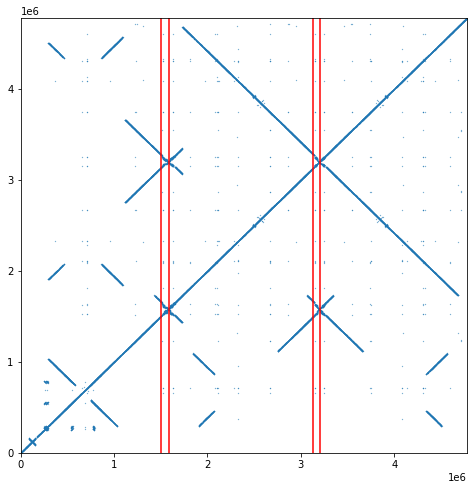

In [7]:
ref_file_name, roi_chr, roi_b, roi_e = \
('hg38_tagged.fa', 
'chrY_hg38', 
23129355, 
24907040)
#DAZ1_len = 23199094-23129355
#DAZ2_len = 23291356-23219434

padding = 1500000
DAZ1_s = 23129355-23129355 + padding
DAZ2_s = 23219434-23129355 + padding
DAZ3_s = 24763069-23129355 + padding
DAZ4_s = 24833919-23129355 + padding
roi_len = roi_e - roi_b
#get a segment of a reference
roi_seq = ref_db.get_sub_seq(ref_file_name, roi_chr, roi_b-padding, roi_e+padding)
x, y = pgrtk.get_shmmr_dots(roi_seq, roi_seq, 128, 56, 6, 32)
plt.figure(figsize=(8,8))
plt.plot(x, y, ".", markersize=0.5)
print(x[0])
plt.plot((DAZ1_s, DAZ1_s),(0,len(roi_seq)),'r-')
plt.plot((DAZ2_s, DAZ2_s),(0,len(roi_seq)),'r-')
plt.plot((DAZ3_s, DAZ3_s),(0,len(roi_seq)),'r-')
plt.plot((DAZ4_s, DAZ4_s),(0,len(roi_seq)),'r-')

plt.xlim(0,len(roi_seq))
plt.ylim(0,len(roi_seq))

In [8]:
#find hits in the pangenomic reference
aln_range = pgrtk.query_sdb(sdb, roi_seq, merge_range_tol=100000)

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 1
The total aligned regions is 5


We can examine, the target region sizes.

In [9]:
rgn_lengths = []
for k in list(aln_range.keys()):
    b, e = aln_range[k][0][0:2]
    print(sdb.seq_info[k], "target region", b, "-", e, "len:", e-b )
    rgn_lengths.append(e-b)

('chrY_hg002', 'v2.7.XY', 62460029) target region 7231462 - 7291494 len: 60032


Text(0, 0.5, 'count')

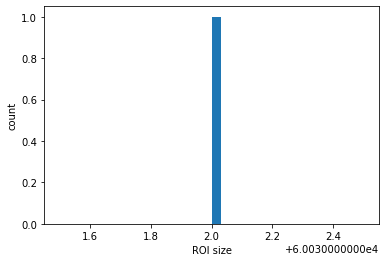

In [10]:
plt.hist(rgn_lengths, bins=32);
plt.xlabel("ROI size")
plt.ylabel("count")

Some mapped regions are larger, let's check the repeat / CNV by quick dot plots. We label the region of the ROI by two vertical grey lines. We observe that there are different number of intersections (~different copy number of the ROI) of the region the "dots" due to the different repeat structures.

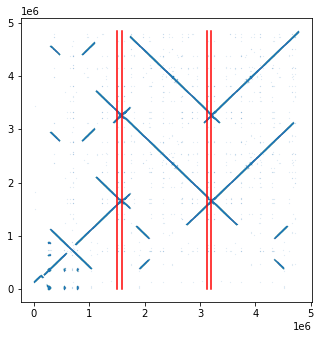

In [11]:
seq_list = []
i = 1
plt.figure(figsize=(24, 24))
for k in list(aln_range.keys()):
    ctg_name, source, _ = sdb.seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()

    rgns = pgrtk.merge_regions(rgns, tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        aln.sort()
  
        #if aln[0][0][0] > padding or aln[-1][0][1] < padding + roi_len:
        #    continue
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        if e-b < 0.75 * (roi_len + 2 * padding):             
            continue
        #print(b, e)
        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
        #seq =  sdb.get_seq(source, ctg_name)
  
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)

        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        x, y = pgrtk.get_shmmr_dots(roi_seq, seq, 128, 56, 4, 1)
        
        
        if i <= 36:
            plt.subplot(4,4,i)
            plt.plot(x, y, ".", markersize=0.1)
            #plt.plot([padding, padding],[0, max(y)], color='grey')
            #plt.plot([padding+roi_len, padding+roi_len],[0, max(y)], color='grey')
        i += 1
        plt.plot((DAZ1_s, DAZ1_s),(0,len(seq)),'r-')
        plt.plot((DAZ2_s, DAZ2_s),(0,len(seq)),'r-')
        plt.plot((DAZ3_s, DAZ3_s),(0,len(seq)),'r-')
        plt.plot((DAZ4_s, DAZ4_s),(0,len(seq)),'r-')
        
 
        

## Create a new shimmer database for the detailed study

In [12]:
seq_list = []
seq_info = sdb.seq_info.copy()
i = 0
for k in list(aln_range.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()
    
    rgns = pgrtk.merge_regions(rgns,tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        if e-b < 0.75 * (roi_len + 2 * padding):             
            continue
            
        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        i += 1



Create a shimmer indext database with smaller window (denser shimmers)

In [13]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=6, min_span=18)

In [14]:
len(new_sdb.seq_info)

1

In [15]:
#find hits in the pangenomic reference
aln_range0 = pgrtk.query_sdb(new_sdb, roi_seq, merge_range_tol=300000)

aln_range = aln_range0

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 1
The total aligned regions is 1


Let's loop through the hits (contigs that has alignments) and see the number of "copies".

In [16]:
from collections import Counter

In [17]:
n_copy = {}
for k in list(aln_range.keys()):
    n_copy[k] = len(aln_range[k])
copy_count = Counter(n_copy.values())
for nc, nh in copy_count.items():
    print("number of copy: {}, number of haplotypes: {}".format(nc, nh))

number of copy: 1, number of haplotypes: 1


Text(0, 0.5, 'count')

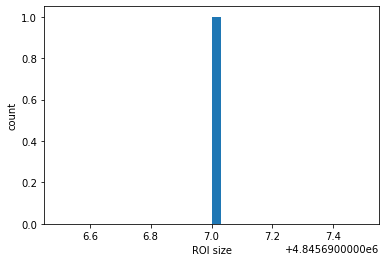

In [18]:
rgn_lengths = []
for k in list(aln_range.keys()):
    for sid, rgns in aln_range.items():
        for rgn in rgns:
            b, e = rgn[0:2]
            #print(seq_index[k], "target region", b, "-", e, "len:", e-b )
            rgn_lengths.append(e-b)
plt.hist(rgn_lengths, bins=32);
plt.xlabel("ROI size")
plt.ylabel("count")

## Generate Repeat Pattern Using the Principal Bundles

In [19]:
shmmrspec = {"w": 64, "k":56, "r":1, "min_span":28 }
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, 
                           w = shmmrspec["w"], 
                           k = shmmrspec["k"], 
                           r = shmmrspec["r"], 
                           min_span = shmmrspec["min_span"])

In [20]:
principal_bundles, sid_smps = new_sdb.get_principal_bundle_decomposition(0,8)
sid_smps = dict(sid_smps)
print(len(principal_bundles))

176


In [21]:
import numpy as np
from matplotlib import cm

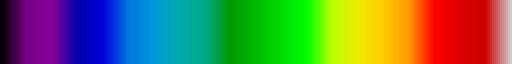

In [22]:
cmap=plt.get_cmap("nipy_spectral")
cmap

In [23]:
lpb = len(principal_bundles)
color_theme0 = cmap(np.linspace(0.1, 0.9, lpb))
#pseudo-randomize the colors
idx = np.array([_ * (lpb+8011) for _ in range(lpb)]) % lpb
print(idx)
color_theme = color_theme0[idx]

[  0  91   6  97  12 103  18 109  24 115  30 121  36 127  42 133  48 139
  54 145  60 151  66 157  72 163  78 169  84 175  90   5  96  11 102  17
 108  23 114  29 120  35 126  41 132  47 138  53 144  59 150  65 156  71
 162  77 168  83 174  89   4  95  10 101  16 107  22 113  28 119  34 125
  40 131  46 137  52 143  58 149  64 155  70 161  76 167  82 173  88   3
  94   9 100  15 106  21 112  27 118  33 124  39 130  45 136  51 142  57
 148  63 154  69 160  75 166  81 172  87   2  93   8  99  14 105  20 111
  26 117  32 123  38 129  44 135  50 141  56 147  62 153  68 159  74 165
  80 171  86   1  92   7  98  13 104  19 110  25 116  31 122  37 128  43
 134  49 140  55 146  61 152  67 158  73 164  79 170  85]


In [24]:
new_sdb.generate_mapg_gfa(0, "/results/test_48_56_4_28.gfa")

v_to_name = {}
with open("/results/test_48_56_4_28.gfa") as f:
    for r in f:
        r = r.strip().split("\t")
        if r[0] != "S":
            continue
        n = r[1]
        v = r[4].split(":")[-1]
        v_to_name[v] = n

f = open("/results/test_48_56_4_28_color.csv", "w")
print("Name,Color", file=f)
for bundle_id, bundle in enumerate(principal_bundles):
    for v in bundle[2]:
        vertex = tuple(v[:2])
        color = color_theme[bundle_id]
  
        print(v_to_name["{:016x}_{:016x}".format(*vertex)], color, file=f, sep=",")
f.close()

In [25]:
b_vertex_to_position = {}
i = 0
for bundle in principal_bundles:
    for v in bundle[2]:
        vertex = tuple(v[:2])
        b_vertex_to_position[vertex] = i, bundle[0]
        i += 1

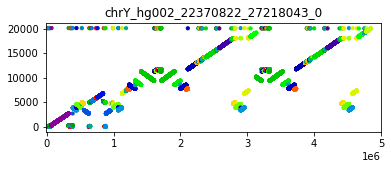

In [26]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

#fig = plt.figure(figsize=(24,96))
pidx = 1
for sid, data in sinfo[:10]:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []

   
    for s in smps:
        if s[1] is None:
            continue
        vertex = tuple(s[0][:2])
        x.append(s[0][2])
        y.append(b_vertex_to_position[vertex][0]) # same direction
        c.append(color_theme[s[1][0]])
            

    fig = plt.figure(figsize=(6,2))
    plt.scatter(x, y, marker=".", color=c, s=40)
    
    
    plt.xlim(-10000,5000000)
    plt.title(ctg)
    

In [27]:
ref_file_name, daz1_chr, daz1_b, daz1_e = \
('hg38_tagged.fa', 
'chrY_hg38', 23129355, 
23199094)
DAZ1_len = 23199094-23129355
DAZ2_len = 23291356-23219434
padding = 100
#roi_len = roi_e - roi_b
#get a segment of a reference
DAZ1_seq = ref_db.get_sub_seq(ref_file_name, daz1_chr, daz1_b-padding, daz1_e+padding)

ref_file_name, daz2_chr, daz2_b, daz2_e = \
('hg38_tagged.fa', 
'chrY_hg38', 23219434, 
23291356)
DAZ1_len = 23199094-23129355
DAZ2_len = 23291356-23291356
padding = 100
#roi_len = roi_e - roi_b
#get a segment of a reference
DAZ2_seq = ref_db.get_sub_seq(ref_file_name, daz2_chr, daz2_b-padding, daz2_e+padding)

ref_file_name, daz3_chr, daz3_b, daz3_e = \
('hg38_tagged.fa', 
'chrY_hg38', 24763069, 
24813492)

padding = 100
#roi_len = roi_e - roi_b
#get a segment of a reference
DAZ3_seq = ref_db.get_sub_seq(ref_file_name, daz3_chr, daz3_b-padding, daz3_e+padding)


ref_file_name, daz4_chr, daz4_b, daz4_e = \
('hg38_tagged.fa', 
'chrY_hg38', 24833919, 
24907040)

padding = 100
#roi_len = roi_e - roi_b
#get a segment of a reference
DAZ4_seq = ref_db.get_sub_seq(ref_file_name, daz4_chr, daz4_b-padding, daz4_e+padding)



In [28]:
gene_matches1 = new_sdb.get_match_positions_with_fragment(DAZ1_seq)
gene_matches2 = new_sdb.get_match_positions_with_fragment(DAZ2_seq)
gene_matches3 = new_sdb.get_match_positions_with_fragment(DAZ3_seq)
gene_matches4 = new_sdb.get_match_positions_with_fragment(DAZ4_seq)
gene_matches = [gene_matches1, gene_matches2, gene_matches3, gene_matches4]

<Figure size 1728x4608 with 0 Axes>

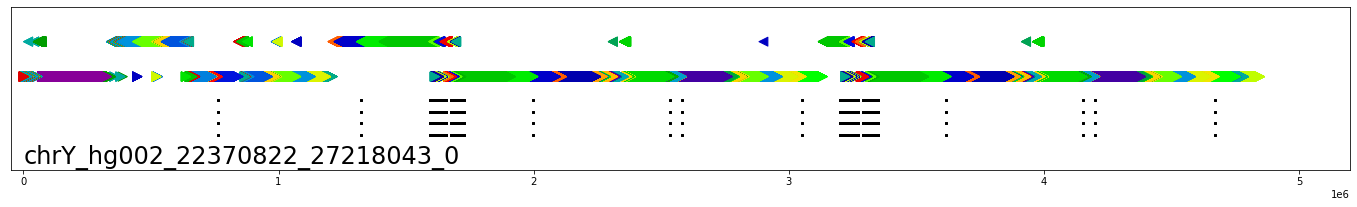

In [30]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

fig = plt.figure(figsize=(24,64))
# pidx = 1
for sid, data in sinfo:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])
        # if tuple(s[0][2:4]) in matches:
        #     track0_x.append(s[0][2])
        #     track0_c.append(fcolors[s[1][0]])
            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    # plt.subplot(len(sid_smps), 1, pidx)
    # pidx += 1
    
    plt.figure(figsize=(24,3))
    plt.scatter(x, y, marker=">", color=c, s=80)
    plt.scatter(rx, ry, marker="<", color=rc, s=80)
    
    
    for mi in range(4):
        matches = set([(_[0], _[1]) for _ in gene_matches[mi][sid]])
        track_x = [_[0] for _ in matches]
        plt.scatter(track_x, [-4-mi*2]*len(track_x), marker="s", color="black", s=2)
  
    
    
    #track0_x = [_[0] for _ in gene_matches[sid]]
    #plt.scatter(track0_x, [-6]*len(track0_x), marker="s", color="black", s=20)
    
    #plt.axis("off")
    plt.yticks([])
    plt.ylim(-16,12)
    plt.xlim(-50000,5200000)
    plt.text(0, -15, ctg, fontsize=24)